# Feature engineering

As noted previously, there are no missing values in the dataset. Also, there are very few outliers compared to the data size.

I will first **split the data into training and test set**, and do feature engineering only on the training set, in order to avoid **data leakage**. Afterwards, I will apply these transformations to the test set. I will not use a validation set yet, since this serves as a helping step for initial model building. **Cross-validation** will be implemented during the model tuning and validation stage, and there I will have a separate test set for a final model validation.

For numerical variables, **scaling** is highly recommended because it helps some of the models, like linear regression and regularized regression, perform better. My choice is using **standardization**, but the other techniques like **min-max** scaling can be implemented. I will **one-hot encode** categorical variables, since it doesn't assume any kind of ordering between categories.

I will use the metric called **Mutual Information** to detect relationship between the predictor variables and the target. Mutual information has an advantage over metrics like Pearson's  or Spearman's correlation because it can detect nonlinear relationships in the data. 

Additionally, I will perform **feature transformation**, including transforming existing features or creating new ones by combining the predictors.

In [40]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [29]:
anxiety_data = pd.read_csv("enhanced_anxiety_dataset.csv")
anxiety_data.head()

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0


First, since I found in the statistical testing stage that the variable **Therapy Sessions (per month)** has a moderate right skew, I will apply the logarithmic transformation on this column to see if this reduces skewness. Since $log(x)$ is not defined for $0$, I will use `log1p` function which is $log(x+1)$ to avoid the infinity.

In [30]:
therapy_sessions = anxiety_data['Therapy Sessions (per month)']

# Check skew before transformation
print(f"Skewness before log transform: {therapy_sessions.skew():.4f}")

# apply log transformation
therapy_log = np.log1p(therapy_sessions) 

# Check skew after log transformation
print(f"Skewness after log transform: {therapy_log.skew():.4f}")

# add transformed feature to a dataframe
anxiety_data['Log Therapy Sessions (per month)'] = therapy_log

Skewness before log transform: 1.0351
Skewness after log transform: -0.1195


The logarithmic transformation reduced the skew - now the column has a minor left skew, but it's still pretty symmetric, which is desirable for modeling. 

Since Stress Levels and Sleep hours are powerful predictors of anxiety according to the EDA and statistical testing changes, perhaps calculating the amount of stree per hour of sleep would further amplify the signal. 

I am interested how the lifestyle choices, such as excercising and consuming high-quality diet might impact anxiety levels, and I can include them in a dataset - however, in the model building stage, I will include the interaction terms, so this combination will emerge on its own. Hence, I choose not to make the separate column for this combination yet. 


In [31]:
anxiety_data['Stress Level per Sleep Hour'] = anxiety_data['Stress Level (1-10)'] / anxiety_data['Sleep Hours']

anxiety_data

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),...,Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10),Log Therapy Sessions (per month),Stress Level per Sleep Hour
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,...,14,4,No,Yes,3,Yes,7,5.0,1.386294,1.666667
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,...,23,2,Yes,No,2,No,8,3.0,1.098612,0.161290
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,...,28,3,No,No,1,Yes,1,1.0,0.693147,0.200000
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,...,17,3,No,No,0,No,1,2.0,0.000000,0.689655
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,...,19,4,Yes,Yes,1,No,3,1.0,0.693147,0.121951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,23,Female,Engineer,6.1,3.1,566,9,Yes,No,8,...,28,1,Yes,Yes,1,No,3,6.0,0.693147,1.311475
10996,50,Other,Teacher,6.6,3.6,64,17,Yes,No,7,...,17,3,No,No,2,No,7,3.0,1.098612,1.060606
10997,29,Male,Nurse,6.7,6.9,159,14,No,No,8,...,16,1,Yes,Yes,2,Yes,7,4.0,1.098612,1.194030
10998,53,Other,Artist,5.7,2.7,248,8,No,No,4,...,28,3,Yes,Yes,1,Yes,2,4.0,0.693147,0.701754


Now, I will get subsets of an original dataframe by selecting a part contatining only numerical, and only categorical variables. For categorical features, it is recommended with one-hot encoding that the columns have low cardinality ($<15$ values in that specific column). This is because one-hot encoding creates new columns in the data, so having too many unique values in the column would lead to many more encoded columns.

In [32]:
# get a dataframe with only categorical variables
categorical_variables = anxiety_data.select_dtypes(include = ['object'])

# get a dataframe with only numerical variables
numerical_variables = anxiety_data.select_dtypes(include = ['int64', 'float64'])

# checking low cardinality columns
low_cardinality_cols = [col for col in categorical_variables.columns if categorical_variables[col].nunique() < 15]


# print the results
print(f"Numerical columns: {list(numerical_variables.columns)}\n")
print(f"Categorical columns: {list(categorical_variables.columns)}\n")
print(f"Low cardinality columns: {low_cardinality_cols}")

Numerical columns: ['Age', 'Sleep Hours', 'Physical Activity (hrs/week)', 'Caffeine Intake (mg/day)', 'Alcohol Consumption (drinks/week)', 'Stress Level (1-10)', 'Heart Rate (bpm)', 'Breathing Rate (breaths/min)', 'Sweating Level (1-5)', 'Therapy Sessions (per month)', 'Diet Quality (1-10)', 'Anxiety Level (1-10)', 'Log Therapy Sessions (per month)', 'Stress Level per Sleep Hour']

Categorical columns: ['Gender', 'Occupation', 'Smoking', 'Family History of Anxiety', 'Dizziness', 'Medication', 'Recent Major Life Event']

Low cardinality columns: ['Gender', 'Occupation', 'Smoking', 'Family History of Anxiety', 'Dizziness', 'Medication', 'Recent Major Life Event']


Luckily, for this dataset all categorical columns have low cardinality, so they can be one-hot encoded without problems. I will now split the data into predictors and a target variable, and then split the data into a training and test sets. As stated before, I will avoid using a separate validation set since this will serve just as an initial exploration step for choosing the model.

In [33]:
# preparing prediction and target features
X = anxiety_data.drop(columns = ['Anxiety Level (1-10)'])
y = anxiety_data[['Anxiety Level (1-10)']]

# split the data into training and test set (80% train_valid, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Now I will one-how encode categorical columns in the training set using `fit_transform`, and apply these changes to a test set with `transform` - this ensures no data leakage. After one-hot encoding, since new columns are created, by default `OH_encoder` creates a sparse matrix by default (for memory efficiency purposes), which needs to be converted to a dataframe in order to work with it in Pandas. Since this process also removes the indices of columns, the index will be assigned back manually.

In [34]:
# encode categorical columns
OH_encoder = OneHotEncoder(drop='first')
OH_train_sparse = OH_encoder.fit_transform(X_train[low_cardinality_cols])
OH_test_sparse = OH_encoder.transform(X_test[low_cardinality_cols])

# convert sparse matrix to dense array
OH_train = pd.DataFrame(OH_train_sparse.toarray(), 
                        columns=OH_encoder.get_feature_names_out(low_cardinality_cols),
                        index=X_train.index)
OH_test = pd.DataFrame(OH_test_sparse.toarray(), 
                       columns=OH_encoder.get_feature_names_out(low_cardinality_cols),
                       index=X_test.index)

# put back the index of columns after it has been removed
OH_train.index = X_train.index
OH_test.index = X_test.index

# match the index of transformed features
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# ensure all column name are strings (optional)
OH_train.columns = OH_train.columns.astype(str)
OH_test.columns = OH_test.columns.astype(str)

OH_train

,Gender_Male,Gender_Other,Occupation_Athlete,Occupation_Chef,Occupation_Doctor,Occupation_Engineer,Occupation_Freelancer,Occupation_Lawyer,Occupation_Musician,Occupation_Nurse,Occupation_Other,Occupation_Scientist,Occupation_Student,Occupation_Teacher,Smoking_Yes,Family History of Anxiety_Yes,Dizziness_Yes,Medication_Yes,Recent Major Life Event_Yes
628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6297,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
9252,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5365,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
10414,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
9845,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
10799,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


The baseline category for Occupation is 'Artist', and for Gender is 'Female'. For binary categorical variables, the baseline category is the one where individuals answered 'No'.

Now, I will standardize numerical predictors, and drop the target column Anxiety Level from this dataframe.

In [35]:
numerical_predictor_vars = numerical_variables.drop(columns=['Anxiety Level (1-10)'])

# initialize a standard scaler
scaler = StandardScaler()

# scale the training data and apply to the test set
X_train[numerical_predictor_vars.columns] = scaler.fit_transform(X_train[numerical_predictor_vars.columns])
X_test[numerical_predictor_vars.columns] = scaler.transform(X_test[numerical_predictor_vars.columns])

Lastly, what's left is to combine the columns in order to get the complete training and test sets, so I will use `pd.concat` method for this.

In [36]:
# concatenate numerical and categorical encoded columns
X_train_final = pd.concat([X_train[numerical_predictor_vars.columns], OH_train], axis=1)
X_test_final = pd.concat([X_test[numerical_predictor_vars.columns], OH_test], axis=1)

# reset index
X_train_final.reset_index(drop=True, inplace=True)
X_test_final.reset_index(drop=True, inplace=True)

# print the results to check if transformations were successful
print(f"Total number of predictor columns: {X_train_final.shape[1]}")

Total number of predictor columns: 32


In [37]:
X_train_final

,Age,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Therapy Sessions (per month),...,Occupation_Nurse,Occupation_Other,Occupation_Scientist,Occupation_Student,Occupation_Teacher,Smoking_Yes,Family History of Anxiety_Yes,Dizziness_Yes,Medication_Yes,Recent Major Life Event_Yes
0,0.652006,-0.038134,-1.059829,0.611726,0.408951,-1.650677,1.159192,-1.738955,-1.475779,-0.652060,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.048630,-0.038134,-0.187960,0.701817,0.058467,-0.284428,1.216778,-1.738955,-0.761155,0.268618,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
2,0.350318,-0.529341,0.193483,-0.919829,1.285160,0.057134,0.583339,1.166089,-0.761155,-0.652060,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.878272,0.289338,1.065353,-1.065361,0.408951,0.740259,0.237827,-1.157946,-0.046532,-1.112400,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.576584,-0.283737,-0.841862,-0.268399,1.460402,1.081821,0.295413,-0.964277,0.668092,1.189297,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,-1.459810,0.944280,-0.460419,-0.947550,0.058467,1.081821,0.986436,-1.545285,1.382716,-0.652060,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
8796,-1.158122,-2.002962,-1.332288,2.094770,0.759434,1.081821,0.583339,0.972420,1.382716,2.570315,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
8797,0.048630,0.371206,0.792893,0.597865,-1.343468,0.057134,1.447119,-0.770607,1.382716,0.268618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
8798,1.783337,1.108016,-0.078976,-0.143656,1.460402,-1.309115,-1.604903,0.391411,1.382716,-0.652060,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


Finally, I will now do Mutual Information analysis.  Mutual Information is an univariate metric, meaning it cannot detect interactions between features, but it can capture a nonlinear relationship between an individual predictor and a target.

In [43]:
# select only numerical columns on the training set
X_train_numeric = X_train.select_dtypes(include=['int64', 'float64'])


# function that computes the MI scores and makes a dataframe
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    print("MI scores for numerical predictors:")
    return mi_scores

mi_scores = make_mi_scores(X_train_numeric, y_train['Anxiety Level (1-10)'], discrete_features=False)
mi_scores

MI scores for numerical predictors:


Stress Level per Sleep Hour          0.501250
Stress Level (1-10)                  0.382223
Log Therapy Sessions (per month)     0.181935
Sleep Hours                          0.170443
Therapy Sessions (per month)         0.163544
Caffeine Intake (mg/day)             0.102979
Diet Quality (1-10)                  0.064720
Physical Activity (hrs/week)         0.064546
Heart Rate (bpm)                     0.054370
Breathing Rate (breaths/min)         0.051311
Age                                  0.045041
Sweating Level (1-5)                 0.037460
Alcohol Consumption (drinks/week)    0.008898
Name: MI Scores, dtype: float64

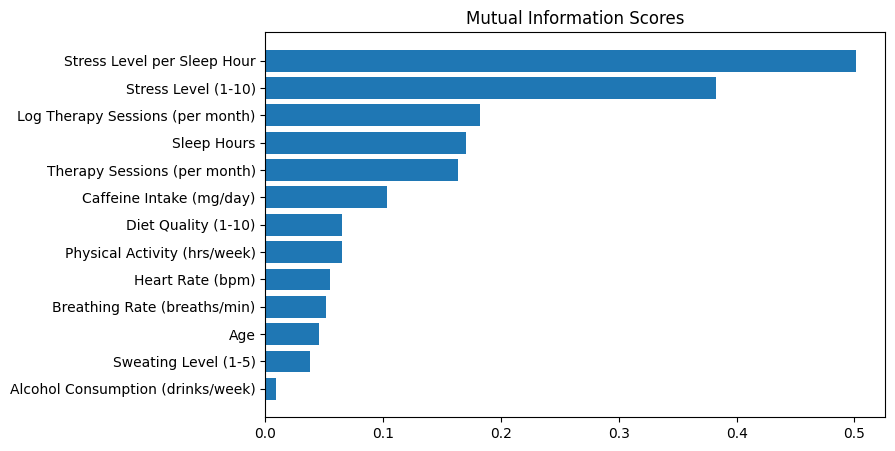

In [44]:
# create a function to plot MI scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

From the Mutual Information testing results, it is clear that the ratio `Stress Level per Sleep Hour = Stress Levels / Sleep Hours` has the largest effect on anxiety, with a score of $0.51$. It is followed by these predictors by themselves, with $0.37$ and $0.19$ for Stress Level and Sleep Hours respectively. From the MI score for Therapy Sessions, there is only slight difference for the log-transformed and untransformed column, the logarithm doesn't add much information. Other predictors have smaller contributions, with Alcohol Consumtion contributing the least to the anxiety levels.

Finally, I will save the preprocessed training and test sets to reuse during the model building stage:

In [27]:
# save the datasets to a folder
X_train_final.to_csv("X_train_final.csv", index=False)
X_test_final.to_csv("X_test_final.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

## Key Takeaways

* The dataset doesn't contain missing values, so there was no imputation of values.
* **Features** are **created** before splitting the data, while **scaling** is done after **train-test split** because scaling depends on the statistic.
* The data is split into **training** and **test sets**, because the goal of the next stage is to roughly examine potential models. **Cross-validation** will be used in the model tuning stage.
* For numerical features:
    * Scaled features using **standardization**, which is useful for models such as linear and regularized regression.
    * Performed logarithmic transformation of **Therapy Sessions**, due to its moderate skewness.
    * Created a new feature **Stress Level per Sleep Hour = Stress Levels / Sleep Hours**, which represents stress levels per hour of sleep.
* For categorical features: performed **one-hot encoding** for all features, since they all have low **cardinality** ($<15$)
* Computed **mutual information (MI) scores** for numerical features:
    * New variable **Stress Level per Sleep Hour** has the highest MI score $0.51$, meaning it's the best anxiety predictor.
    * **Stress Level** and **Sleep Hours** individually are the next best predictors, with MI scores of  $0.37$ and $0.19$.
    * **Therapy Sessions** and **Log Therapy Sessions** have a similar MI score, indicating that the log-transformation is likely unnecessary.
    * **Caffeine Intake**, **Diet Quality** etc. are less important features, with **Alcohol Consumption** having the least impact on anxiety with a MI score of $0.0009$.

**Next steps**:
* Build several models, such as **linear regression**, **random forest**, **XGBoost** and train them on the training set.
* **Evaluate models** on a test set, based on the chosen metric (like RMSE, MAE for regression).
* Check linear regression assumptions: **linearity**, **homoscedasticity**, **normality of residuals**, and **multicollinearity**.
* Perform **feature importance** for random forest and XGBoost, to see the contribution of each feature.